In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
!pip install pytorch-lightning torchbench

import torch
from torch import nn
import numpy as np
import pytorch_lightning as pl
from torchbench.datasets import ADE20K
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, pil_to_tensor, resize, normalize
from torchvision.transforms import InterpolationMode
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm

In [7]:
def simple_ade20k_transforms(image, target):
    image = resize(to_tensor(image), (256, 256))
    image = normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    target = resize(pil_to_tensor(target), (64, 64), InterpolationMode.NEAREST)[0].long()
    # 0: background, -1: plant, -2: person/animal, -3: vehicle
    class_mapping = [(5, -1), (10, -1), (13, -2), (18, -1), (21, -3), (67, -1),
                     (77, -3), (84, -3), (91, -3), (103, -3), (104, -3), (127, -2), (128, -3)]
    for cm in class_mapping:
        target[target == cm[0]] = cm[1]
    target[target > 0] = 0
    target *= -1
    return image, target

In [8]:
train_dataset = ADE20K('data', 'train', download=True, transforms=simple_ade20k_transforms)
val_dataset = ADE20K('data', 'val', transforms=simple_ade20k_transforms)

You set download=True, but a folder VOCdevkit already exist in the root directory. If you want to re-download or re-extract the archive, delete the folder.


In [9]:
def trim_dataset(dataset):
    valid_indices = []
    for entry in tqdm(range(len(dataset))):
        _, target = dataset[entry]
        if (target > 0).float().mean() > 0.01:
            valid_indices.append(entry)
    if len(dataset) > len(valid_indices):
        dataset = Subset(dataset, valid_indices)
    return dataset

train_dataset = trim_dataset(train_dataset)
val_dataset = trim_dataset(val_dataset)

  0%|          | 0/20210 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 2000/2000 [00:09<00:00, 211.36it/s]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


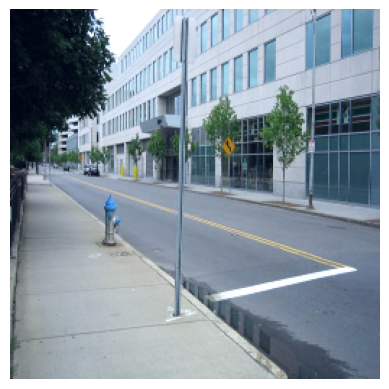

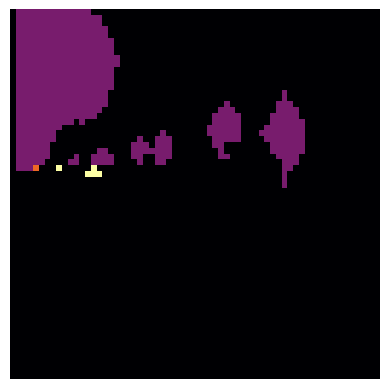

In [12]:
idx = 600
plt.imshow(train_dataset[idx][0].permute(1, 2, 0) / 4 + 0.5) # just for visualization
plt.axis('off')
plt.show()
plt.imshow(train_dataset[idx][1], vmin=0, vmax=3, cmap='inferno')
plt.axis('off')
plt.show()

In [13]:
train_dataset[idx][1].shape

torch.Size([64, 64])

In [1]:
!pip install pytorch-lightning pycocotools

In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-10-11 13:40:35--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.158.137.102, 108.158.137.88, 108.158.137.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.158.137.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  22.4MB/s    in 15s     

2023-10-11 13:40:51 (23.5 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [3]:
!pip install safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00


In [39]:
from utils import *
from sam_lora import *



sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
lora_sam = LoRA_Sam(sam,r = 4)

In [40]:
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [41]:
from torch.utils.data import Subset
indices = range(50)
subset_dataset = Subset(train_dataset, indices)

In [42]:
num_epochs = 10
device = 'cuda'
optimizer = torch.optim.Adam(lora_sam.sam.parameters(), lr=1e-5)
lora_sam.sam.to(device)
criteria = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  running_loss = 0.0
  running_cate_loss = 0.0
  running_mask_loss = 0.0
  running_iou_loss = 0.0

  pbar = tqdm(subset_dataset, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

  for image0, targets in pbar:
    optimizer.zero_grad()

    image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
    image = image.to(device)

    target = targets[None, :]  # TODO: batch
    target_tensor = target.clone()
    batch_size, height, width = target_tensor.shape
    one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
    one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
    selected_target = one_hot_target
    selected_target = selected_target[0, 0]

    selected_target = selected_target.to(device)

    features = lora_sam.sam.image_encoder(image)

    sparse_embeddings, dense_embeddings = lora_sam.sam.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
                )

    image_pe_scaled = lora_sam.sam.prompt_encoder.get_dense_pe()

    # dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
    # image_pe_orig = lora_sam.sam.prompt_encoder.get_dense_pe()
    # image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

    low_res_masks, iou_predictions = lora_sam.sam.mask_decoder(
                image_embeddings=features,
                image_pe=image_pe_scaled,
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )


    selected_target = F.interpolate(selected_target[None, None, :], size=(256, 256), mode='bilinear')
    # print('selected_target: ', selected_target.shape)
    selected_target = selected_target.to(device)

    # # focal_loss = mask_focal_loss(low_res_masks, selected_target)
    # dice_loss = mask_dice_loss(low_res_masks, selected_target)
    # iou_loss = iou_token_loss(iou_predictions, low_res_masks, selected_target)

    # # loss = focal_loss + dice_loss + iou_loss
    # loss = dice_loss + iou_loss

    # loss = criteria(low_res_masks, selected_target)
    loss = mask_dice_loss(low_res_masks, selected_target)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    # running_cate_loss += focal_loss.item()
    # running_mask_loss += dice_loss.item()
    # running_iou_loss += iou_loss.item()

    # pbar.set_postfix({
    #           'Total Loss': f"{running_loss / (pbar.n + 1):.4e}",
    #           'Cate Loss': f"{running_cate_loss / (pbar.n + 1):.4e}",
    #           'Mask Loss': f"{running_mask_loss / (pbar.n + 1):.4e}",
    #           'IoU Loss': f"{running_iou_loss / (pbar.n + 1):.4e}"
    #       })

    pbar.set_postfix({
              'Total Loss': f"{running_loss / (pbar.n + 1):.4e}"
          })



Epoch [10/10]: 100%|██████████| 50/50 [00:13<00:00,  3.65it/s, Total Loss=5.8005e-02]


In [106]:
idx_ = 6

image0 = subset_dataset[idx_][0]
targets = subset_dataset[idx_][1]

In [107]:

image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
image = image.to(device)

target = targets[None, :]  # TODO: batch
target_tensor = target.clone()
batch_size, height, width = target_tensor.shape
one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
selected_target = one_hot_target
selected_target = selected_target[0, 0]

selected_target = selected_target.to(device)

features = lora_sam.sam.image_encoder(image)

sparse_embeddings, dense_embeddings = lora_sam.sam.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
            )

image_pe_scaled = lora_sam.sam.prompt_encoder.get_dense_pe()

# dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
# image_pe_orig = lora_sam.sam.prompt_encoder.get_dense_pe()
# image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

low_res_masks, iou_predictions = lora_sam.sam.mask_decoder(
            image_embeddings=features,
            image_pe=image_pe_scaled,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

In [108]:
low_res_masks.shape
mask_plot = low_res_masks[0, 0].cpu().detach().numpy()
mask_gt_plot = selected_target.cpu().detach().numpy()
image_plot = image0.permute(1, 2, 0).cpu().detach().numpy()

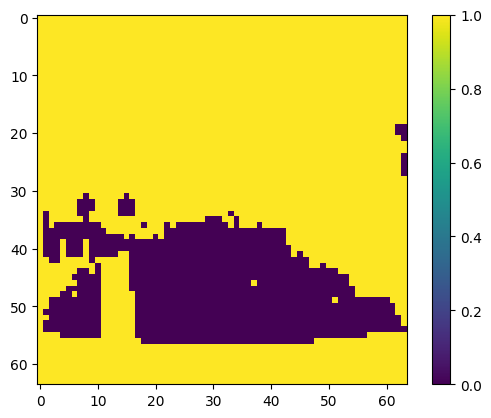

In [109]:
img = plt.imshow(mask_gt_plot)
plt.colorbar(img)
plt.show()

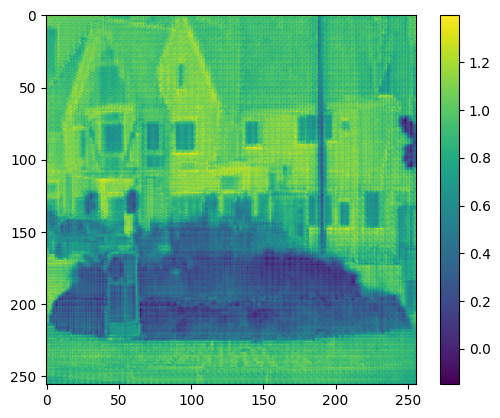

In [110]:
img = plt.imshow(mask_plot)
plt.colorbar(img)
plt.show()

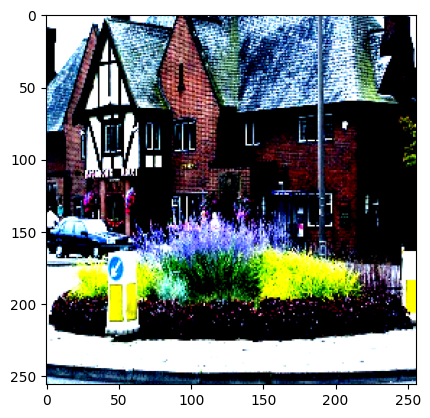

In [111]:
plt.imshow(image_plot)
plt.show()

In [112]:
sam_2 = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
lora_sam_2 = LoRA_Sam(sam_2,r = 4)

lora_sam_2.sam.to(device)
print(1)

1


In [113]:
# idx_ = 20

image0 = subset_dataset[idx_][0]
targets = subset_dataset[idx_][1]



image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
image = image.to(device)

target = targets[None, :]  # TODO: batch
target_tensor = target.clone()
batch_size, height, width = target_tensor.shape
one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
selected_target = one_hot_target
selected_target = selected_target[0, 0]

selected_target = selected_target.to(device)

features = lora_sam_2.sam.image_encoder(image)

sparse_embeddings, dense_embeddings = lora_sam_2.sam.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
            )

image_pe_scaled = lora_sam_2.sam.prompt_encoder.get_dense_pe()

# dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
# image_pe_orig = lora_sam_2.sam.prompt_encoder.get_dense_pe()
# image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

low_res_masks, iou_predictions = lora_sam_2.sam.mask_decoder(
            image_embeddings=features,
            image_pe=image_pe_scaled,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

In [114]:
low_res_masks.shape
mask_plot = low_res_masks[0, 0].cpu().detach().numpy()
mask_gt_plot = selected_target.cpu().detach().numpy()
image_plot = image0.permute(1, 2, 0).cpu().detach().numpy()

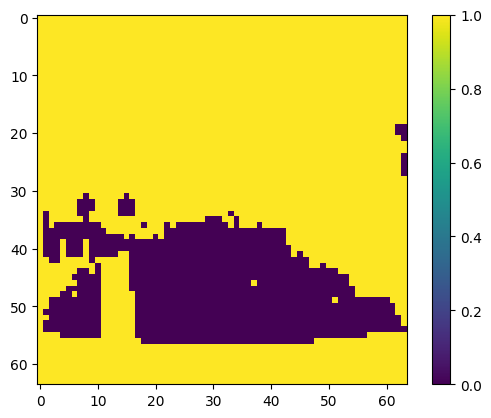

In [115]:
img = plt.imshow(mask_gt_plot)
plt.colorbar(img)
plt.show()

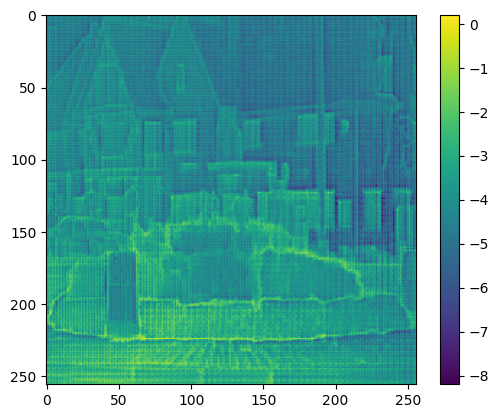

In [116]:
img = plt.imshow(mask_plot)
plt.colorbar(img)
plt.show()

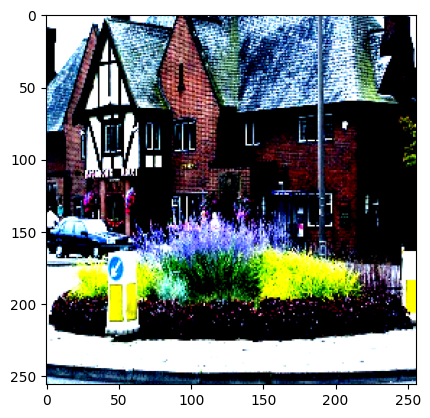

In [117]:
plt.imshow(image_plot)
plt.show()